# **CDS Project: Part 3**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  

## Learning objectives
---

- Choose an ML model architecture for vulnerability prediction
- Preprocess the dataset you created in project part 2 to fit the model you selected
- Split the dataset for cross validation
- Create the model training pipeline, train the model using the train set and optimize the model using the test set
- Create loss graphs of the learning behaviour
- Generate predictions for the validation set
- Evaluate the results using appropriate metrics (add questions: reduce overfitting? optional 5-fold cross validation)


## Materials
---

- Lecture Slides 2, 3, 5 and 6, 9.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
- 


## Project Description

In this project, you will create, train and evaluate your own machine learning model to predict vulnerabilities in source code. In addition, you will preprocess the data to prepare it to be used in the learning pipeline.
You will be using the dataset created in part 2 in this part. 

## **Task 1**

- There are several ML model architectures that you can use for vulnerabilitiy prediction such as RNN, CNN, Multilabel Perceptron (MLP), Gated Recurrent Units (GRU) and so on. Choose a suitable ML model architecture for your project based on the strenghts and weaknesses of these algorithms.

- For the model architecture, you can choose from 2 paths:
  1. Preprocess the functions into vectors and continue the learning process similar to project 1.
  For instance, the code in the dataset needs to be converted into some type of vector representation that can be processed by a machine. After selecting a suitable model, preprocess the content in your dataset accordingly. Several models are available to preprocess code data such as:
    - Code2Vec: https://code2vec.org/
    - CodeBERT: https://github.com/microsoft/CodeBERT/tree/master/UniXcoder
    - CodeT5: https://github.com/salesforce/CodeT5

  2. Choose a model architecture that is capable of handeling raw text inputs (LSTM, GRU, etc.) as an input layer. Further information on text processing using pytorch:
    - https://pytorch.org/text/stable/index.html
    - https://pytorch.org/tutorials/


	•	Check for missing or broken values
	•	Understand how many samples we have per class (0 or 1)

## Task 2

- Split your dataset appropriately into train, test, and validation set and justify your split.  

In [ ]:
# TODO: Load the dataset

# TODO: Split the dataset into train, test and validation set

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import seaborn as sns

In [ ]:
# TODO: Load the dataset
import pandas as pd

# Load your dataset
df = pd.read_csv("~/Desktop/TUHH/Semester 2 /Cybersecurity in Data Science/lab/vulnerability_dataset_all.csv")

# Display a few rows to make sure it's loaded correctly
print(df.head())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Class distribution (vulnerable vs non-vulnerable)
print("\nLabel distribution:\n", df['label'].value_counts())

                                       function_code  label
0  def getServerPrincipalDetails(service, hostnam...      1
1  def getServerPrincipalDetails(service, hostnam...      0
2  static PyObject *checkPassword(PyObject *self,...      1
3  static PyObject *checkPassword(PyObject *self,...      0
4  static krb5_error_code verify_krb5_user(krb5_c...      1

Missing values:
 function_code    0
label            0
dtype: int64

Label distribution:
 label
0    4273
1    3103
Name: count, dtype: int64


In [2]:
#Code -> Tokens 

from transformers import RobertaTokenizer, RobertaModel
import torch

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)

# Set model to evaluation mode
codebert_model.eval()

/Users/esraduran/Desktop/TUHH/Semester 2 /Cybersecurity in Data Science/lab/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/esraduran/Desktop/TUHH/Semester 2 /Cybersecurity in Data Science/lab/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [20]:
#Tokens -> Vectors
from tqdm import tqdm

def get_embeddings(texts, batch_size=8, max_length=512):
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            ).to(device)

            outputs = codebert_model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu()  # CLS token
            all_embeddings.append(embeddings)

    return torch.cat(all_embeddings, dim=0)

In [34]:
texts = df["function_code"].tolist()
labels = df["label"].values

embeddings = get_embeddings(texts)

Generating Embeddings: 100%|██████████| 922/922 [28:09<00:00,  1.83s/it]


In [35]:
# TODO: Split the dataset into train, test and validation set

from sklearn.model_selection import train_test_split

# 80% train, 20% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

# 50% val, 50% test 
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 5900
Validation size: 738
Test size: 738


## Task 3
- Create a preprocessing and training/test pipeline. This can also be done in separate steps.
- Train the model on a small dataset (e.g.: 1000 samples depending on the computational capacity) and make sure everything is working properly
- Show a graph showing the changes in loss function druring the training epochs 
- Select proper metrics to evaluate the performance of the model
- If everything works well, then change the model parameters (e.g: number of neurons, layer depth) and regenerate the results. Comapare these results with your previous results and elaborate your findings.

In [36]:
# TODO: Implement your ML pipeline and perform evaluation

import torch.nn as nn

class VulnerabilityClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [38]:
import torch
from torch.utils.data import Dataset

class CodeDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, torch.Tensor):
            self.features = features.float()
        else:
            self.features = torch.tensor(features, dtype=torch.float32)

        if isinstance(labels, torch.Tensor):
            self.labels = labels.float().unsqueeze(1)
        else:
            self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = CodeDataset(X_train, y_train)
val_dataset = CodeDataset(X_val, y_val)
test_dataset = CodeDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [39]:
import torch.optim as optim

# Move model to device 
model = VulnerabilityClassifier(input_dim=embeddings.shape[1]).to(device)

# Binary Cross Entropy Loss 
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [40]:
num_epochs = 50  
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/50 => Train Loss: 0.6823, Val Loss: 0.6759
Epoch 2/50 => Train Loss: 0.6806, Val Loss: 0.6763
Epoch 3/50 => Train Loss: 0.6805, Val Loss: 0.6757
Epoch 4/50 => Train Loss: 0.6797, Val Loss: 0.6766
Epoch 5/50 => Train Loss: 0.6798, Val Loss: 0.6764
Epoch 6/50 => Train Loss: 0.6801, Val Loss: 0.6762
Epoch 7/50 => Train Loss: 0.6798, Val Loss: 0.6764
Epoch 8/50 => Train Loss: 0.6792, Val Loss: 0.6791
Epoch 9/50 => Train Loss: 0.6787, Val Loss: 0.6791
Epoch 10/50 => Train Loss: 0.6789, Val Loss: 0.6766
Epoch 11/50 => Train Loss: 0.6786, Val Loss: 0.6764
Epoch 12/50 => Train Loss: 0.6778, Val Loss: 0.6768
Epoch 13/50 => Train Loss: 0.6775, Val Loss: 0.6771
Epoch 14/50 => Train Loss: 0.6780, Val Loss: 0.6796
Epoch 15/50 => Train Loss: 0.6784, Val Loss: 0.6774
Epoch 16/50 => Train Loss: 0.6765, Val Loss: 0.6809
Epoch 17/50 => Train Loss: 0.6776, Val Loss: 0.6759
Epoch 18/50 => Train Loss: 0.6760, Val Loss: 0.6763
Epoch 19/50 => Train Loss: 0.6762, Val Loss: 0.6768
Epoch 20/50 => Train 

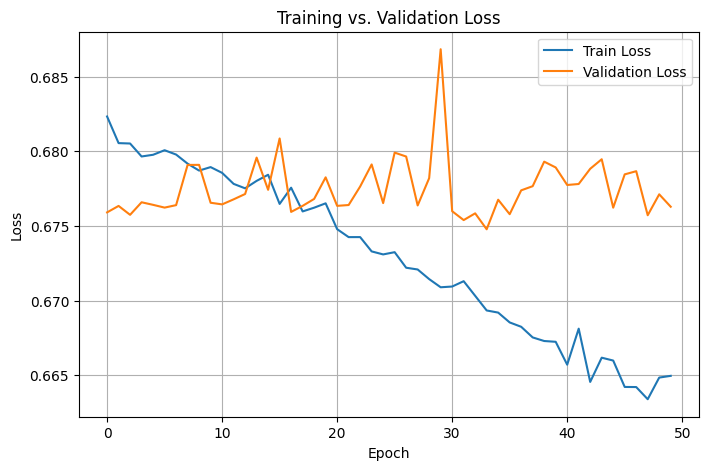

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.86      0.69       428
         1.0       0.45      0.16      0.24       310

    accuracy                           0.56       738
   macro avg       0.52      0.51      0.47       738
weighted avg       0.53      0.56      0.50       738



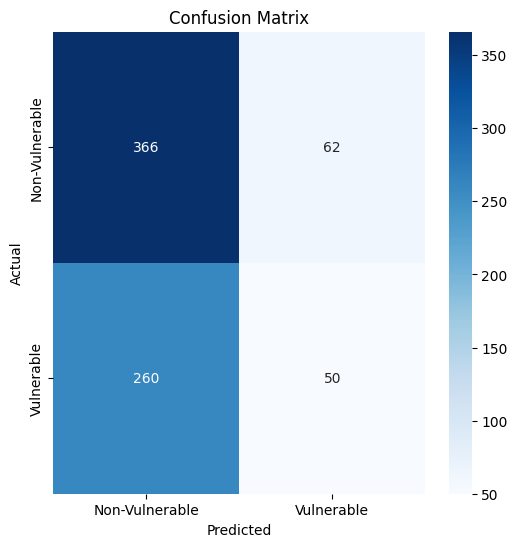

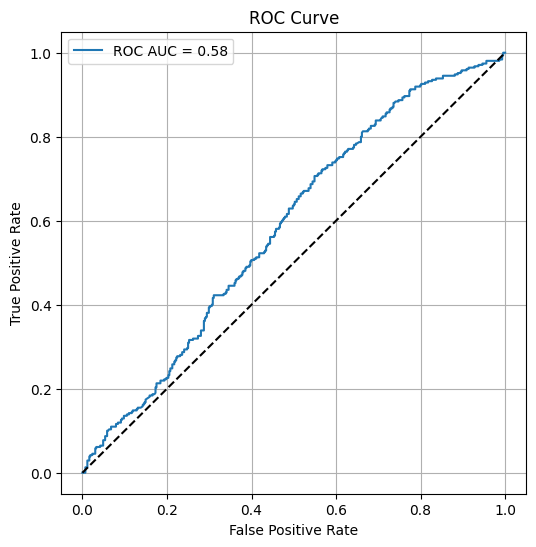

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def full_evaluation(model, loader, threshold=0.5):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = torch.sigmoid(model(x)).cpu().numpy()
            all_probs.extend(outputs)
            all_labels.extend(y.numpy())
    
    y_true = np.array(all_labels).flatten()
    y_pred = (np.array(all_probs).flatten() > threshold)
    

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))  


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Vulnerable', 'Vulnerable'],
                yticklabels=['Non-Vulnerable', 'Vulnerable'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, all_probs)
    roc_auc = roc_auc_score(y_true, all_probs)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return roc_auc

# Evaluate on test set
test_auc = full_evaluation(model, test_loader)